In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Multiple Linear Regression for advertising campaing

The adverstiting dataset captures sales revenue generated with respect to advertisement spends across multiple channles

In [3]:
df = pd.read_csv('data/advertising.csv', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Basic EDA

In [4]:
print("\nInformation of the dataset: ")
print(df.info())
print("\nSummary Statistics ")
df.describe()


Information of the dataset: 
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB
None

Summary Statistics 


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000



Missing values: 
TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Checking for Outliers: 


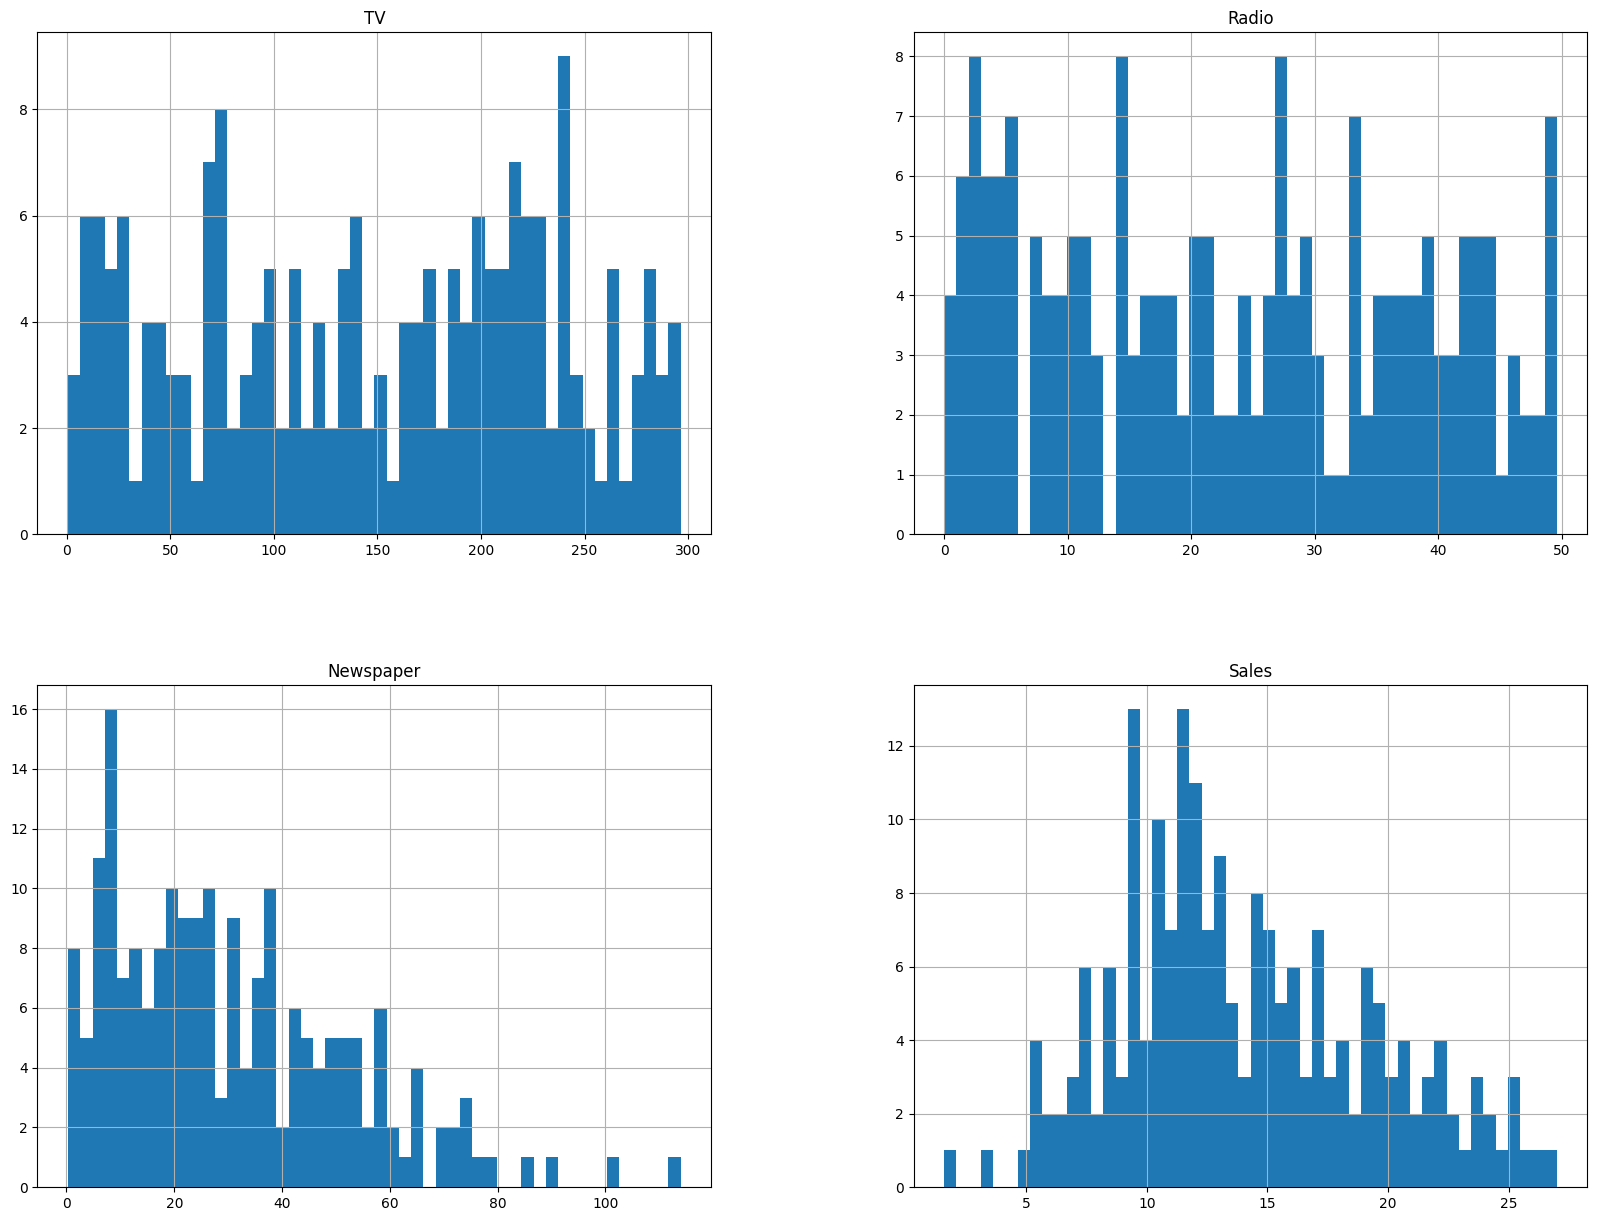

In [5]:
# Check for any missing values
print("\nMissing values: ")
print(df.isnull().sum())

# Check for outliers
print("\nChecking for Outliers: ")
df.hist(bins=50, figsize=(20,15))
plt.show()

No anomalies or inconsistencies found in the data, we can continue by checking first model assumption

### Checking Linear Regression model assumption (1): Linearity

/Users/user/Documents/Projects/air_polution/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


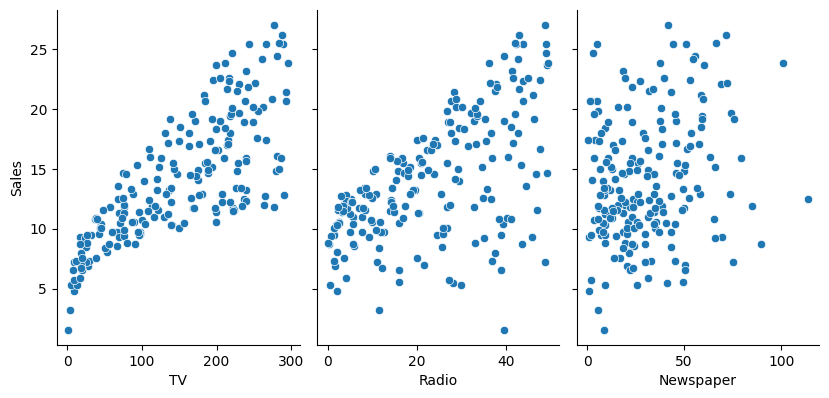

In [6]:
# Relationship between Features and target variable: Linearity (1)
sns.pairplot(df, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', height=4, aspect=0.7)
plt.show()

Tv and Radio have strong linear relationship as for newspaper there seems to be a random cloud

## Estimating Coefficients

In [7]:
X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

lml = LinearRegression()
lml.fit(X, y)

print("\nIntercept: ", lml.intercept_)
print("\nCoefficients: ", lml.coef_)


Intercept:  2.9388893694594014

Coefficients:  [ 0.04576465  0.18853002 -0.00103749]


Radio seems to have strongest positive correlation with Sales
Newspaper coefficient is nearly zero

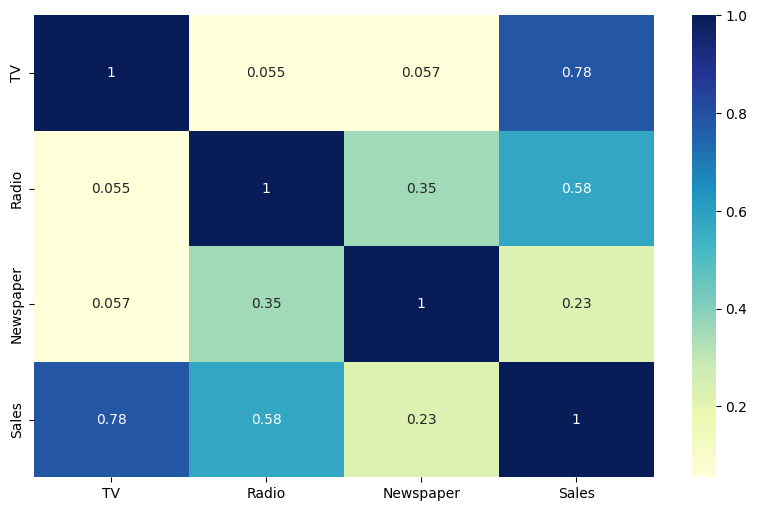

In [8]:
# Correlation matrix heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

### Feature Selection

In [9]:
from sklearn.metrics import r2_score

lm2 = LinearRegression().fit(X[['TV', 'Radio']], y) 
lm2_preds = lm2.predict(X[['TV', 'Radio']])

lm3 = LinearRegression().fit(X[['TV', 'Radio', 'Newspaper']], y)
lm3_preds = lm3.predict(X[['TV', 'Radio', 'Newspaper']])

print("R-squared for the model with two features: ", r2_score(y, lm2_preds))
print("R-squared for the model with three features: ", r2_score(y, lm3_preds))

R-squared for the model with two features:  0.8971942610828957
R-squared for the model with three features:  0.8972106381789522


We can drop nwespaper as it has no effect on the model and is liklely going to cause overfitting / decrease performance.

In [27]:
# Feature Selection & Data Splitting
X = df[['TV', 'Radio']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# Training the model

model = LinearRegression()
model.fit(X_train, y_train)

print(model.intercept_)
print(model.coef_)

2.8376172369051815
[0.04407736 0.20260566]


In [29]:
# Model Evaluation

y_pred = model.predict(X_test)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R-squared: ", metrics.r2_score(y_test, y_pred))

Root Mean Squared Error: 1.915475673176426
R-squared:  0.8656253548947074


## Model Interpretation

Based on our metrics, our linear regression model seems to perform reasonably well. 

The R-squared value of 0.8656 (or 86.56%) indicates that the model can explain around 86.56% of the variance in the Sales from our features

the RMSE value of 1.915 shows that there is still some error in our predictions. This is the average error the model makes in predicting the Sales. This suggests there might be other factors influencing Sales that our model does not account for.

While this model shows good predictive power, there may be room for improvement. For instance, we could consider using different types of regression models, such as polynomial regression, or even more complex models like random forests or gradient boosting. Further, feature engineering might allow us to uncover more complex relationships within the data.


## Incorporating Interaction Terms

In the original model, we assumed that the effects of 'TV' and 'Radio' on 'Sales' are independent of each other. However, in some cases, spending on one advertising medium may actually enhance the effect of the other medium, leading to a synergistic effect. (violation of linear regression assumption)

To account for this, we create an 'interaction' term that multiplies the 'TV' and 'Radio' features together. This term will allow our model to learn the effect of advertising on TV and Radio together on Sales.


In [30]:
df['interaction'] = df['TV'] * df['Radio']

X = df[['TV', 'Radio', 'interaction']]
y = df['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
lm_preds = lm.predict(X_test)

print("R-squared: ", r2_score(y_test, lm_preds))
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, lm_preds)))

R-squared:  0.9732737582951896
RMSE:  0.8502085687189503


With the interaction term, we capture the combined effect of TV and Radio advertising budgets on Sales. This is a significant improvement over our initial model. Reason is advertising mediums often influence each other.
